<table style="width: 100%;"> <tr> <td style="width: 20%; vertical-align: top;"> <img src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" alt="UdeA" height="150px"> </td> <td style="width: 80%; padding-left: 20px;"> <strong style="font-size: 30px;">MODELO DE REDES NEURONALES CONVOLUCIONALES PARA UN SISTEMA DE CLASIFICACIÓN CON IMÁGENES DE RESONANCIA MAGNÉTICA </strong><br><br> <span style="font-size: 30px;"> Luisa Fernanda Alzate Cuartas <br> Juan Camilo Henao Caro<br>Isabella Mendez Hoyos<br> Fernando Antonio Piñeres Ramos </span> </td> </tr> </table>

#### IMPORTE E INSTALACIÓN DE LIBRERÍAS

In [2]:
# Conectar con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Instalación de librerías.
!pip install optuna

In [4]:
import sys #Interactuar de manera directa con el intérprete de Python
import os #Se utiliza para interactuar con el sistema operativo
path = '/content/drive/MyDrive/operaciones' # Configura el entorno para trabajar con archivos en Google Drive
sys.path.append(path) # Permite importar módulos desde esta ruta.
os.chdir(path) # Cambia el directorio de trabajo actual

In [5]:
# Importe de librerías.
import optuna #Para el ajuste de hiperparámetros.
import numpy as np  #Manipulación de estructuras de datos matriciales y funciones matemáticas de alto nivel.
import pandas as pd #Manipulación y transformación de datos.
import tensorflow as tf # Permite crear y entrenar redes neuronales, procesar datos y gestionar modelos para diversas aplicaciones.
from sklearn import metrics #. Funciones de puntuación, métricas de rendimiento, métricas por pares y cálculos de distancia.
from sklearn.metrics import roc_auc_score #Calcular el área bajo la curva característica operativa del receptor (ROC AUC) a partir de los puntajes de predicción.
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Permite expandir los datos de entrenamiento de la imagen, mediante el uso de transformaciones como rotaciones aleatorias, transformaciones de corte, cambios, zooms y giros, en los datos de imagen disponibles.
from tensorflow.keras.models import Sequential #Apropiado para una pila simple de capas donde cada capa tiene exactamente un tensor de entrada y un tensor de salida .
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization #Para construir una red neuronal convolucional compleja que pueda procesar y aprender de datos de imágenes, textos secuenciales, o cualquier otro dato que pueda ser representado en una cuadrícula 2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint ### Importación de Callbacks para el Control del Entrenamiento
#Los Callbacks son herramientas poderosas que nos permiten monitorear y controlar el proceso de entrenamiento del modelo, ayudando a optimizar el rendimiento y la eficiencia.
from sklearn.utils import shuffle #´Para que el modelo no aprenda de un orden específico y para asegurar que el entrenamiento sea más robusto.
import joblib #Para guardar y cargar modelos de machine learning.
#Guardar el modelo una vez entrenado para no tener que entrenarlo de nuevo cada vez que lo necesites usar.
import random
from tensorflow.keras.utils import to_categorical

#### LECTURA DEL CONJUNTO DE IMÁGENES

In [6]:
#Cargar el conjunto de datos(imágenes) a usar para el modelo.
x_train = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_test.pkl')
x_val = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/x_val.pkl')
y_val = joblib.load('/content/drive/MyDrive/operaciones/salidas/data_final/y_val.pkl')

#### EXPLORACIÓN DEL CONJUNTO DE DATOS(IMÁGENES)

In [6]:
display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)
display(x_val.shape)
display(y_val.shape)

(5553, 160, 160, 3)

(5553,)

(695, 160, 160, 3)

(695,)

(694, 160, 160, 3)

(694,)

#### ESCALADO DEL CONJUNTO DE DATOS.

In [7]:
#### Escalar ######################
x_train=x_train.astype('float32') ## para poder escalarlo
x_test=x_test.astype('float32') ## para poder escalarlo
x_train.max()
x_train.min()


x_train /=255 ### escalarlo para que quede entre 0 y 1, con base en el valor máximo
x_test /=255

###### verificar tamaños

x_train.shape
x_test.shape

np.prod(x_train[1].shape) ## cantidad de variables por imagen

display(np.unique(y_train, return_counts=True))
display(np.unique(y_test, return_counts=True))

(array([0, 1, 2, 3]), array([1232, 1316, 1600, 1405]))

(array([0, 1, 2, 3]), array([154, 165, 200, 176]))

#### DATA AUGMENTATION

In [8]:

# Crear el generador de augmentación
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest' #se rellena los pixeles vacios con el pixel mas cercano
)

# Función para balancear un conjunto de datos (train o test)
def balance_dataset(x, y, datagen):
    classes, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    x_aug = []
    y_aug = []

    for c in classes:
        x_class = x[y == c]
        y_class = y[y == c]
        n_samples_needed = max_count - len(x_class)

        # Agregar los datos originales
        x_aug.extend(x_class)
        y_aug.extend(y_class)

        # Generar muestras augmentadas si es necesario
        if n_samples_needed > 0:
            # Reshape para que datagen.flow funcione correctamente con un solo lote
            x_class_reshaped = np.expand_dims(x_class, axis=1)
            y_class_reshaped = np.expand_dims(y_class, axis=1)

            gen = datagen.flow(x_class, y_class, batch_size=1)
            for _ in range(n_samples_needed):
                x_gen, y_gen = next(gen)
                x_aug.append(x_gen[0])
                y_aug.append(y_gen[0])

    # Convertir a arrays numpy
    x_balanced = np.array(x_aug)
    y_balanced = np.array(y_aug)

    # Barajar (opcional pero recomendable)
    x_balanced, y_balanced = shuffle(x_balanced, y_balanced, random_state=42)

    return x_balanced, y_balanced

# Aumentar el conjunto de entrenamiento
x_train_balanced, y_train_balanced = balance_dataset(x_train, y_train, datagen)

# Aumentar el conjunto de prueba
x_test_balanced, y_test_balanced = balance_dataset(x_test, y_test, datagen)

# Guardar los conjuntos balanceados si deseas
joblib.dump(x_train_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/x_train_balanced.pkl')
joblib.dump(y_train_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/y_train_balanced.pkl')
joblib.dump(x_test_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/x_test_balanced.pkl')
joblib.dump(y_test_balanced, '/content/drive/MyDrive/operaciones/salidas/data_final/y_test_balanced.pkl')

# Verificar las distribuciones después del balanceo
display(np.unique(y_train_balanced, return_counts=True))
display(np.unique(y_test_balanced, return_counts=True))

(array([0, 1, 2, 3]), array([1600, 1600, 1600, 1600]))

(array([0, 1, 2, 3]), array([200, 200, 200, 200]))

In [9]:
y_train_balanced = to_categorical(y_train_balanced, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [10]:
y_train_balanced.shape

(6400, 4)

#### MODELO DE REDES NEURONALES CONVOLUSIONALES.

In [14]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'



inputs = tf.keras.Input(shape=x_train_balanced.shape[1:])
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='last_conv')(x)  # IMPORTANTE para Grad-CAM
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

cnn_model = tf.keras.Model(inputs=inputs, outputs=outputs)
cnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,957,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,962,724 (11.30 MB)

 Trainable params: 2,962,724 (11.30 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#compilación del modelo
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])

In [16]:
early_stopping = EarlyStopping(
    monitor='val_AUC',
    patience=3,
    mode='max',
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
    verbose=1
)


history = cnn_model.fit(
    x_train_balanced, y_train_balanced,
    validation_data=(x_test_balanced, y_test_balanced),
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    batch_size=100
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - AUC: 0.7840 - loss: 1.0589

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(100,), output.shape=(100, 4)

In [14]:
import matplotlib.pyplot as plt

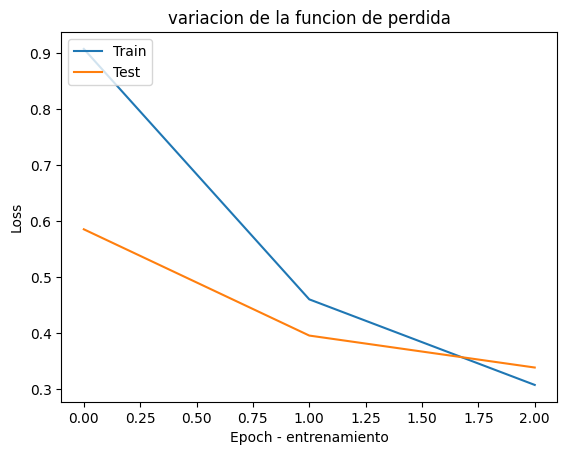

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('variacion de la funcion de perdida')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

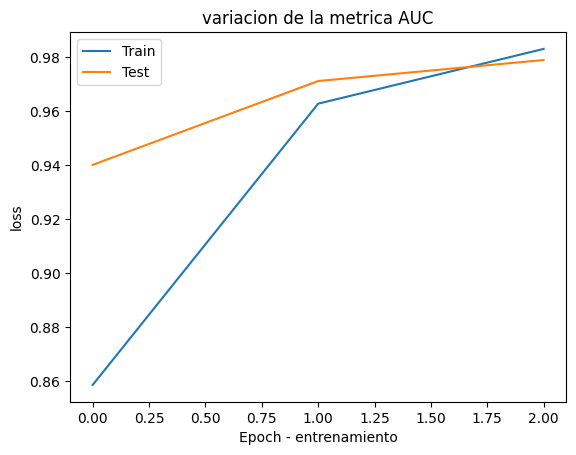

In [16]:
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('variacion de la metrica AUC')
plt.ylabel('loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#######probar una red con regulzarización L2
reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.1

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=x_train_balanced.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model with binary cross-entropy loss and Adam optimizer
cnn_model2.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=[tf.keras.metrics.AUC(name='auc')])

checkpoint2 = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_AUC',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1
)


# Train the model for 10 epochs
history2 = cnn_model2.fit(x_train_balanced, y_train_balanced, batch_size=100, epochs=2, validation_data=(x_test, y_test), callbacks=checkpoint2)

Epoch 1/2
64/64 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - auc: 0.6460 - loss: 1.6410 - val_auc: 0.9343 - val_loss: 0.7359
Epoch 2/2


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_AUC available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - auc: 0.9210 - loss: 0.7885 - val_auc: 0.9577 - val_loss: 0.6039


In [ ]:
cnn_model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     2,654,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,978,862 (30.44 MB)

 Trainable params: 2,659,620 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,319,242 (20.29 MB)

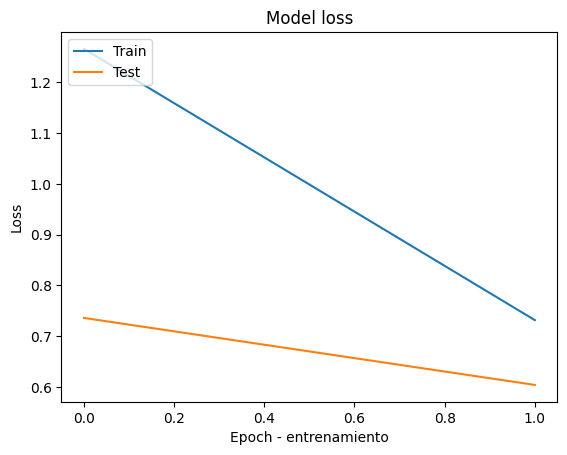

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch - entrenamiento')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
# Función objetivo para utilizar optuna
def objective(trial):
    # grilla de huiperparámetros
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.2, step=0.05)
    reg_strength = trial.suggest_float('reg_strength', 0.0001, 0.0005, step=0.0001)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd'])

    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=x_train_balanced.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    checkpoint3 = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_auc',        # Metric must match name used in model.compile()
    mode='max',               # Use 'max' because higher AUC is better
    save_best_only=True,
    verbose=1)



    # Choose optimizer
    if optimizer_name == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)

    # Compile with AUC metric
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=[tf.keras.metrics.AUC(name='auc')])

    # Train the model
    model.fit(
        x_train_balanced, y_train_balanced,
        epochs=3,
        validation_data=(x_test, y_test),
        batch_size=100,
        verbose=0,
        callbacks=checkpoint3
    )

    model_win=tf.keras.models.load_model('best_model.h5')

    # Predict probabilities and compute AUC manually
    y_pred_prob = model_win.predict(x_test)
    auc = roc_auc_score(y_test, y_pred_prob)

    # Save best model in trial attributes
    trial.set_user_attr("model", model_win)

    return auc

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)

# Get best model
best_trial = study.best_trial
best_model = best_trial.user_attrs["model"]

# Final evaluation
test_loss, test_auc = best_model.evaluate(x_test, y_test)
print(f"\Mejor AUC on test set: {test_auc:.4f}")
best_model.summary()

[I 2025-06-04 12:56:54,044] A new study created in memory with name: no-name-fb0c7fee-cb46-4f27-8826-f8f5238aaa3d



Epoch 1: val_auc improved from -inf to 0.94783, saving model to best_model.h5



Epoch 2: val_auc improved from 0.94783 to 0.96338, saving model to best_model.h5



Epoch 3: val_auc improved from 0.96338 to 0.97366, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
[I 2025-06-04 13:04:14,939] Trial 0 finished with value: 0.9690525235262804 and parameters: {'dropout_rate': 0.05, 'reg_strength': 0.0001, 'optimizer': 'adam'}. Best is trial 0 with value: 0.9690525235262804.


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - auc: 0.9706 - loss: 0.4259
\Mejor AUC on test set: 0.9737


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     2,654,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,978,862 (30.44 MB)

 Trainable params: 2,659,620 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,319,242 (20.29 MB)